# Updates

In [1]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import json

start_time = "2004-12-24 09:00:00"
end_time = "2004-12-24 10:30:00"

# Initialize the BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views2", "route-views3", "route-views4", "ris-ripe", "bview"],
    record_type="updates"
)

as_announcements = {}

prefix_counter = Counter()
as_path_counter = Counter()
update_message_counter = Counter()

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":  # Check for BGP announcements
            prefix = elem.fields["prefix"]
            as_path = elem.fields["as-path"].split()
            origin_as = as_path[-1]
            timestamp = elem.time 

            if prefix not in as_announcements:
                as_announcements[prefix] = []
            as_announcements[prefix].append((as_path, timestamp))

            prefix_counter[prefix] += 1
            as_path_counter[tuple(as_path)] += 1
            update_message_counter[timestamp] += 1

# Define a function to determine anomaly status
def determine_anomaly_status(update_count, threshold):
    if update_count > threshold:
        return f"anomaly - {update_count} update messages"
    else:
        return "normal"

# Define the anomaly threshold (example: mean + 3*std)
update_counts = list(update_message_counter.values())
threshold = 10000

# Convert data to JSON
data = [{
    'prefix': prefix,
    'as_path': ' -> '.join(path),
    'origin_as': path[-1],  # Get the origin AS from the AS path
    'timestamp': datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S'),
    'update_message_count': update_message_counter[timestamp],
    'anomaly_status': determine_anomaly_status(update_message_counter[timestamp], threshold)
} for prefix, paths in as_announcements.items() for path, timestamp in paths]

# Save data in a JSON file
with open("/home/hb/as_announcements.json", "w") as f:
    json.dump(data, f, indent=4)

# Example of loading and displaying the JSON data (for verification)
with open("/home/hb/as_announcements.json", "r") as f:
    loaded_data = json.load(f)
    # for entry in loaded_data[:5]:  # Display first 5 entries
    #     print(entry)
    
    # Count the total number of entries
    total_count = len(loaded_data)
    
    # Count the number of anomalies
    anomaly_count = sum(1 for entry in loaded_data if "anomaly" in entry['anomaly_status'])
    
    # Count the number of normal status
    normal_count = sum(1 for entry in loaded_data if "normal" in entry['anomaly_status'])
    
    # Print the counts
    print(f"Total number of entries: {total_count}")
    print(f"Number of anomalies: {anomaly_count}")
    print(f"Number of normal status: {normal_count}")

2024-05-23 15:39:10 385682: bgpstream_parsebgp_common.c:587: WARNING: Read truncated record 6011 from 'http://archive.routeviews.org/bgpdata/2004.12/UPDATES/updates.20041224.0918.bz2'
2024-05-23 15:39:10 385682: bgpstream_parsebgp_common.c:587: WARNING: Read truncated record 6017 from 'http://archive.routeviews.org/bgpdata/2004.12/UPDATES/updates.20041224.0918.bz2'
2024-05-23 15:39:10 385682: bgpstream_parsebgp_common.c:587: WARNING: Read truncated record 6027 from 'http://archive.routeviews.org/bgpdata/2004.12/UPDATES/updates.20041224.0918.bz2'
2024-05-23 15:39:10 385682: bgpstream_parsebgp_common.c:587: WARNING: Read truncated record 7037 from 'http://archive.routeviews.org/bgpdata/2004.12/UPDATES/updates.20041224.0918.bz2'
2024-05-23 15:39:10 385682: bgpstream_parsebgp_common.c:587: WARNING: Read truncated record 7041 from 'http://archive.routeviews.org/bgpdata/2004.12/UPDATES/updates.20041224.0918.bz2'
2024-05-23 15:39:10 385682: bgpstream_parsebgp_common.c:587: WARNING: Read trunc

Total number of entries: 5078168
Number of anomalies: 183365
Number of normal status: 4894803


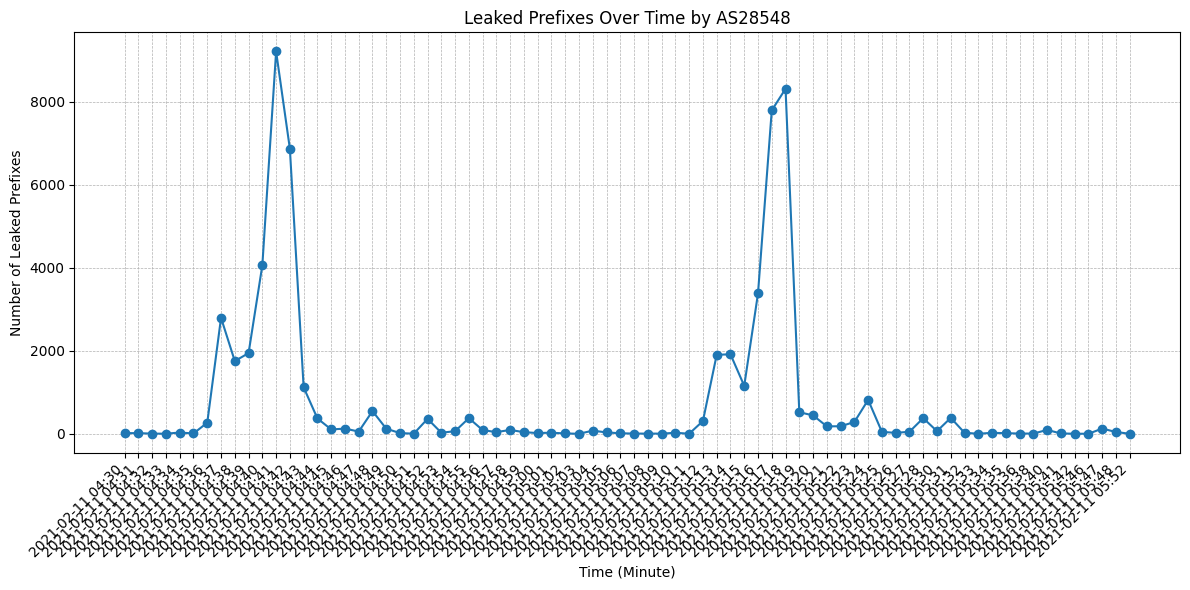

In [3]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window around the incident
start_time = "2021-02-11 04:30:00 UTC"
end_time = "2021-02-11 05:59:59 UTC"

# Target ASN that propagated the leaks
leaking_asn = "28548"

# Initialize BGPStream with an expanded list of collectors
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views.sg", "route-views.eqix"],
    record_type="updates"
)

# Store counts of leaked prefixes over time
leaked_prefixes_over_time = defaultdict(int)

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            as_path = elem.fields["as-path"].split()
            prefix = elem.fields["prefix"]
            if leaking_asn in as_path:
                timestamp_minute = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M')
                leaked_prefixes_over_time[timestamp_minute] += 1

# Visualizing the spike in leaked prefixes over time
timestamps = sorted(leaked_prefixes_over_time.keys())
counts = [leaked_prefixes_over_time[ts] for ts in timestamps]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, counts, marker='o', linestyle='-')
plt.xlabel('Time (Minute)')
plt.ylabel('Number of Leaked Prefixes')
plt.title(f'Leaked Prefixes Over Time by AS{leaking_asn}')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Aggregate

In [ ]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import pandas as pd

# Define the time window around the incident
start_time = "2021-02-11 03:30:00 UTC"
end_time = "2021-02-11 05:59:59 UTC"

# Initialize BGPStream with an expanded list of collectors, focusing on update records
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views.sg", "route-views.eqix"],
    record_type="updates"
)

# Store detailed information and counts
aggregate_bgp_data = []
as_path_history = defaultdict(lambda: defaultdict(list))
summary_stats = defaultdict(lambda: defaultdict(lambda: {'total_prefixes': 0, 'unique_as_paths': set(), 'total_announcements': 0, 'total_withdrawals': 0, 'as_path_changes': 0, 'hijacks': 0}))

# Define a function to detect hijacks (simple example: detecting changes in the origin AS)
def detect_hijack(previous_as_path, current_as_path):
    return previous_as_path[-1] != current_as_path[-1] if previous_as_path and current_as_path else False

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type in {"A", "W"}:  # Check for announcements and withdrawals
            # Extract the fields from the element
            fields = elem.fields
            timestamp = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M')
            collector_project = rec.project
            collector_name = rec.collector
            prefix = fields.get("prefix", "")
            as_path = fields.get("as-path", "").split()
            next_hop = fields.get("next-hop", "")
            origin_as = as_path[-1] if as_path else ""
            community = fields.get("community", "")
            atomic_aggregate = fields.get("atomic-aggregate", "")
            aggregator = fields.get("aggregator", "")
            
            # Collect detailed information
            aggregate_bgp_data.append({
                'timestamp': timestamp,
                'collector_project': collector_project,
                'collector_name': collector_name,
                'origin_as': origin_as,
                'next_hop': next_hop,
                'prefix': prefix,
                'as_path': ' '.join(as_path),
                'community': community,
                'atomic_aggregate': atomic_aggregate,
                'aggregator': aggregator,
                'update_type': elem.type
            })

            # Check for AS path changes and hijacks
            previous_as_path = as_path_history[prefix][origin_as][-1] if as_path_history[prefix][origin_as] else []
            if elem.type == "A":  # Announcement
                summary_stats[origin_as][timestamp]['total_prefixes'] += 1
                summary_stats[origin_as][timestamp]['unique_as_paths'].add(' '.join(as_path))
                summary_stats[origin_as][timestamp]['total_announcements'] += 1

                # Detect AS path changes
                if previous_as_path != as_path:
                    summary_stats[origin_as][timestamp]['as_path_changes'] += 1
                    if detect_hijack(previous_as_path, as_path):
                        summary_stats[origin_as][timestamp]['hijacks'] += 1
                
                # Update AS path history
                as_path_history[prefix][origin_as].append(as_path)

            elif elem.type == "W":  # Withdrawal
                summary_stats[origin_as][timestamp]['total_withdrawals'] += 1

# Convert unique_as_paths sets to their lengths
for as_stats in summary_stats.values():
    for stats in as_stats.values():
        stats['unique_as_paths'] = len(stats['unique_as_paths'])

# Create DataFrames
df_aggregate = pd.DataFrame(aggregate_bgp_data)
df_analysis = pd.concat({origin_as: pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'timestamp'}) for origin_as, data in summary_stats.items()})

# Save the DataFrames to CSV files
df_aggregate.to_csv('aggregate_bgp_data_updates.csv', index=False)
df_analysis.to_csv('bgp_analysis_updates.csv', index=False)

# Display the DataFrames
print("Aggregate DataFrame:")
print(df_aggregate.head())
print("\nAnalysis DataFrame:")
print(df_analysis.head())

In [6]:
df_aggregate

,timestamp,collector_project,collector_name,origin_as,next_hop,prefix,as_path,community,atomic_aggregate,aggregator,update_type
0,2021-02-11 03:30,routeviews,route-views.eqix,23969,206.126.236.214,101.51.56.0/24,57695 3223 2914 3356 38040 23969,,,,A
1,2021-02-11 03:30,routeviews,route-views.eqix,3580,206.126.236.37,68.234.48.0/20,17350 6939 3580,,,,A
2,2021-02-11 03:30,routeviews,route-views.eqix,62587,206.126.238.208,162.250.141.0/24,17350 6939 40676 62587,,,,A
3,2021-02-11 03:30,routeviews,route-views.eqix,131578,206.126.238.208,103.94.12.0/22,17350 2914 6453 4538 4538 131578,,,,A
4,2021-02-11 03:30,routeviews,route-views.eqix,20473,2001:504:0:2:0:1:7350:1,2a0f:9400:8027::/48,17350 6453 3356 20473,,,,A
...,...,...,...,...,...,...,...,...,...,...,...
7232768,2021-02-11 05:59,routeviews,route-views.sg,49252,27.111.228.155,188.211.235.0/24,7713 9002 5483 5483 5483 5483 44682 49252,,,,A
7232769,2021-02-11 05:59,routeviews,route-views.sg,49252,27.111.228.155,89.40.239.0/24,7713 9002 5483 5483 5483 5483 44682 49252,,,,A
7232770,2021-02-11 05:59,routeviews,route-views.sg,202629,27.111.228.155,45.153.28.0/22,7713 9002 202629,,,,A
7232771,2021-02-11 05:59,routeviews,route-views.sg,41712,27.111.228.155,31.148.132.0/23,7713 9002 8926 41221 41712,,,,A


In [11]:
df_analysis

timestamp  total_prefixes  unique_as_paths  \
23969  0  2021-02-11 03:30              85               51   
       1  2021-02-11 03:31              96               52   
       2  2021-02-11 03:32             102               55   
       3  2021-02-11 03:33              77               42   
       4  2021-02-11 03:34              92               51   
...                    ...             ...              ...   
51871  0  2021-02-11 05:59              42               17   
266264 0  2021-02-11 05:59               8                2   
266459 0  2021-02-11 05:59               6                2   
37496  0  2021-02-11 05:59               6                6   
37085  0  2021-02-11 05:59               1                1   

          total_announcements  total_withdrawals  as_path_changes  hijacks  
23969  0                   85                  0               78        0  
       1                   96                  0               88        0  
       2                  102                  0               93        0  
       3                   77                  0               67        0  
       4                   92                  0               84        0  
...                       ...                ...              ...      ...  
51871  0                   42                  0               36        0  
266264 0                    8                  0                8        0  
266459 0                    6                  0                6        0  
37496  0                    6                  0                6        0  
37085  0                    1                  0                1        0  

[365863 rows x 7 columns]

# Ribs

## AS-specific

2024-05-23 13:57:07 382088: bgpstream_filter.c:307: ERROR: record-type filter must be one of "ribs" or "updates"


Aggregate DataFrame:
             timestamp collector_project    collector_name origin_as  \
0  2021-02-11 04:00:04        routeviews  route-views.eqix     28548   
1  2021-02-11 04:00:04        routeviews  route-views.eqix     28548   
2  2021-02-11 04:00:04        routeviews  route-views.eqix     28548   
3  2021-02-11 04:00:04        routeviews  route-views.eqix     28548   
4  2021-02-11 04:00:04        routeviews  route-views.eqix     28548   

          next_hop            prefix                       as_path community  \
0  206.126.238.209  189.202.228.0/24  17350 2914 12956 18734 28548             
1  206.126.238.208  189.202.228.0/24  17350 2914 12956 18734 28548             
2   206.126.238.56  189.202.228.0/24  37468 3356 12956 18734 28548             
3   206.126.236.12  189.202.228.0/24        2914 12956 18734 28548             
4   206.126.237.22  189.202.228.0/24      199524 12956 18734 28548             

  atomic_aggregate aggregator  
0                              
1

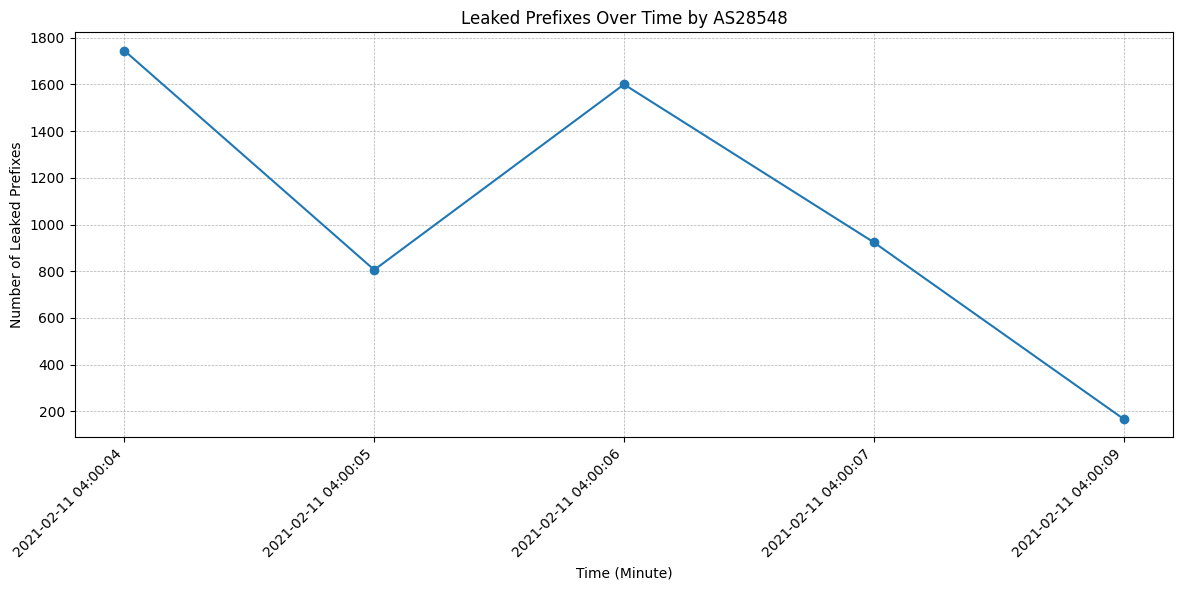

In [14]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import pandas as pd

# Define the time window around the incident
start_time = "2021-02-11 03:30:00 UTC"
end_time = "2021-02-11 05:59:59 UTC"

# Target ASN that propagated the leaks
leaking_asn = "28548"

# Initialize BGPStream with an expanded list of collectors, focusing on RIB records
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views.sg", "route-views.eqix"],
    record_type="rib"
)

# Store detailed information and counts
aggregate_bgp_data = []
summary_stats = defaultdict(lambda: {'total_prefixes': 0, 'unique_as_paths': set(), 'total_announcements': 0, 'total_withdrawals': 0})

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "R":
            # Extract the fields from the element
            fields = elem.fields
            timestamp = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M:%S')
            collector_project = rec.project
            collector_name = rec.collector
            prefix = fields.get("prefix", "")
            as_path = fields.get("as-path", "").split()
            next_hop = fields.get("next-hop", "")
            origin = fields.get("as-path", "").split()[-1]
            community = fields.get("community", "")
            atomic_aggregate = fields.get("atomic-aggregate", "")
            aggregator = fields.get("aggregator", "")

            # Check if the leaking ASN is in the AS path
            if leaking_asn in as_path:
                # Collect detailed information
                aggregate_bgp_data.append({
                    'timestamp': timestamp,
                    'collector_project': collector_project,
                    'collector_name': collector_name,
                    'origin_as': origin,
                    'next_hop': next_hop,
                    'prefix': prefix,
                    'as_path': ' '.join(as_path),
                    'community': community,
                    'atomic_aggregate': atomic_aggregate,
                    'aggregator': aggregator
                })

                # Update summary statistics
                summary_stats[timestamp]['total_prefixes'] += 1
                summary_stats[timestamp]['unique_as_paths'].add(' '.join(as_path))
                summary_stats[timestamp]['total_announcements'] += 1  # Assuming each RIB entry is an announcement
                # No withdrawals in RIB data

# Convert unique_as_paths sets to their lengths
for stats in summary_stats.values():
    stats['unique_as_paths'] = len(stats['unique_as_paths'])

# Create DataFrames
df_aggregate = pd.DataFrame(aggregate_bgp_data)
df_analysis = pd.DataFrame.from_dict(summary_stats, orient='index').reset_index()
df_analysis.rename(columns={'index': 'timestamp'}, inplace=True)

# Save the DataFrames to CSV files
df_aggregate.to_csv('aggregate_bgp_data_as28548.csv', index=False)
df_analysis.to_csv('bgp_analysis_as28548.csv', index=False)

# Display the DataFrames
print("Aggregate DataFrame:")
print(df_aggregate.head())
print("\nAnalysis DataFrame:")
print(df_analysis.head())

# Plot the spike in leaked prefixes over time
timestamps = sorted(df_analysis['timestamp'])
counts = df_analysis['total_prefixes']

plt.figure(figsize=(12, 6))
plt.plot(timestamps, counts, marker='o', linestyle='-')
plt.xlabel('Time (Minute)')
plt.ylabel('Number of Leaked Prefixes')
plt.title(f'Leaked Prefixes Over Time by AS{leaking_asn}')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Aggregate AS

In [12]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import pandas as pd

# Define the time window around the incident
start_time = "2021-02-11 03:30:00 UTC"
end_time = "2021-02-11 05:59:59 UTC"

# Initialize BGPStream with an expanded list of collectors, focusing on RIB records
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views.sg", "route-views.eqix"],
    record_type="ribs"
)

# Store detailed information and counts
aggregate_bgp_data = []
summary_stats = defaultdict(lambda: defaultdict(lambda: {'total_prefixes': 0, 'unique_as_paths': set(), 'total_announcements': 0, 'total_withdrawals': 0}))

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "R":
            # Extract the fields from the element
            fields = elem.fields
            timestamp = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M:%S')
            collector_project = rec.project
            collector_name = rec.collector
            prefix = fields.get("prefix", "")
            as_path = fields.get("as-path", "").split()
            next_hop = fields.get("next-hop", "")
            origin_as = as_path[-1] if as_path else ""
            community = fields.get("community", "")
            atomic_aggregate = fields.get("atomic-aggregate", "")
            aggregator = fields.get("aggregator", "")

            # Collect detailed information
            aggregate_bgp_data.append({
                'timestamp': timestamp,
                'collector_project': collector_project,
                'collector_name': collector_name,
                'origin_as': origin_as,
                'next_hop': next_hop,
                'prefix': prefix,
                'as_path': ' '.join(as_path),
                'community': community,
                'atomic_aggregate': atomic_aggregate,
                'aggregator': aggregator
            })
            # Update summary statistics for the origin AS
            summary_stats[origin_as][timestamp]['total_prefixes'] += 1
            summary_stats[origin_as][timestamp]['unique_as_paths'].add(' '.join(as_path))
            summary_stats[origin_as][timestamp]['total_announcements'] += 1  # Assuming each RIB entry is an announcement
            # No withdrawals in RIB data

# Convert unique_as_paths sets to their lengths
for as_stats in summary_stats.values():
    for stats in as_stats.values():
        stats['unique_as_paths'] = len(stats['unique_as_paths'])

# Create DataFrames
df_aggregate = pd.DataFrame(aggregate_bgp_data)
df_analysis = pd.concat({origin_as: pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'timestamp'}) for origin_as, data in summary_stats.items()})

# Save the DataFrames to CSV files
# df_aggregate.to_csv('aggregate_bgp_data.csv', index=False)
# df_analysis.to_csv('bgp_analysis.csv', index=False)

# Display the DataFrames
print("Aggregate DataFrame:")
print(df_aggregate.head())
print("\nAnalysis DataFrame:")
print(df_analysis.head())


Aggregate DataFrame:
             timestamp collector_project  collector_name origin_as  \
0  2021-02-11 04:00:00        routeviews  route-views.sg      1299   
1  2021-02-11 04:00:00        routeviews  route-views.sg    136168   
2  2021-02-11 04:00:00        routeviews  route-views.sg     13335   
3  2021-02-11 04:00:00        routeviews  route-views.sg     13335   
4  2021-02-11 04:00:00        routeviews  route-views.sg     13335   

         next_hop      prefix          as_path community atomic_aggregate  \
0  27.111.228.222   0.0.0.0/0      199524 1299                              
1  27.111.228.170   0.0.0.0/0           136168                              
2  27.111.228.159  1.0.0.0/24      24482 13335                              
3  27.111.228.201  1.0.0.0/24      14061 13335                              
4   27.111.228.43  1.0.0.0/24  3491 4637 13335                              

  aggregator  
0             
1             
2             
3             
4             

Anal

In [14]:
df_aggregate

,timestamp,collector_project,collector_name,origin_as,next_hop,prefix,as_path,community,atomic_aggregate,aggregator
0,2021-02-11 04:00:00,routeviews,route-views.sg,1299,27.111.228.222,0.0.0.0/0,199524 1299,,,
1,2021-02-11 04:00:00,routeviews,route-views.sg,136168,27.111.228.170,0.0.0.0/0,136168,,,
2,2021-02-11 04:00:00,routeviews,route-views.sg,13335,27.111.228.159,1.0.0.0/24,24482 13335,,,
3,2021-02-11 04:00:00,routeviews,route-views.sg,13335,27.111.228.201,1.0.0.0/24,14061 13335,,,
4,2021-02-11 04:00:00,routeviews,route-views.sg,13335,27.111.228.43,1.0.0.0/24,3491 4637 13335,,,
...,...,...,...,...,...,...,...,...,...,...
29849421,2021-02-11 04:00:10,routeviews,route-views.sg,37125,2001:de8:4::1:8106:1,2c0f:fff0::/32,18106 3741 30988 37125,,,
29849422,2021-02-11 04:00:10,routeviews,route-views.sg,37125,2001:de8:4::6:3956:1,2c0f:fff0::/32,63956 6939 3741 30988 37125,,,
29849423,2021-02-11 04:00:10,routeviews,route-views.sg,37125,2001:de8:4::19:9524:1,2c0f:fff0::/32,199524 6939 3741 30988 37125,,,
29849424,2021-02-11 04:00:10,routeviews,route-views.sg,37125,2001:de8:4::6939:1,2c0f:fff0::/32,7713 6939 3741 30988 37125,,,


In [13]:
df_analysis

timestamp  total_prefixes  \
1299                            0  2021-02-11 04:00:00             441   
                                1  2021-02-11 04:00:01             629   
                                2  2021-02-11 04:00:02             463   
                                3  2021-02-11 04:00:03             293   
                                4  2021-02-11 04:00:04             285   
...                                                ...             ...   
{51923,199835}                  0  2021-02-11 04:00:09               2   
199813                          0  2021-02-11 04:00:10               3   
50546                           0  2021-02-11 04:00:10              10   
{64600,65001,65002,65501,65502} 0  2021-02-11 04:00:10               4   
31128                           0  2021-02-11 04:00:10               1   

                                   unique_as_paths  total_announcements  \
1299                            0               35                  441   
                                1               36                  629   
                                2               35                  463   
                                3               34                  293   
                                4               32                  285   
...                                            ...                  ...   
{51923,199835}                  0                2                    2   
199813                          0                3                    3   
50546                           0                5                   10   
{64600,65001,65002,65501,65502} 0                4                    4   
31128                           0                1                    1   

                                   total_withdrawals  
1299                            0                  0  
                                1                  0  
                                2                  0  
                                3                  0  
                                4                  0  
...                                              ...  
{51923,199835}                  0                  0  
199813                          0                  0  
50546                           0                  0  
{64600,65001,65002,65501,65502} 0                  0  
31128                           0                  0  

[243371 rows x 5 columns]